**Import các thư viện cần thiết**

In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

**Chúng ta sẽ dùng thư viện networkx để khởi tạo một cấu trúc đồ thị gồm 4 websites (A, B, C và D) có các mối quan hệ trích dẫn/được trích dẫn với nhau như bên dưới**

In [ ]:
website_graph = nx.DiGraph()
website_graph.add_edges_from([
	('A', 'B'),
	('A', 'C'),
	('D', 'C'),
	('D', 'C'),
	('C', 'A'),
	('B', 'C')
])

**Trực quan hóa đồ thị các websites: A, B, C và D được xây dựng trong [website_graph]**

{'A': Text(0.6003195479979029, 0.2387636323036129, 'A'),
 'B': Text(-0.11629178858989987, 0.8958618762327842, 'B'),
 'C': Text(-0.1355033084567138, -0.13462550853639718, 'C'),
 'D': Text(-0.34852445095128926, -1.0, 'D')}

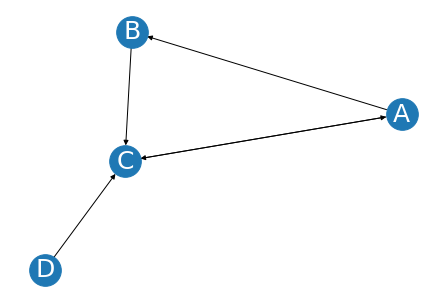

In [ ]:
layout = nx.kamada_kawai_layout(website_graph)
nx.draw(website_graph, layout, node_size=1000)
nx.draw_networkx_labels(website_graph, pos=layout, font_size=25, font_color='white')

**Tiến hành cài đặt thuật toán HITS (Hyper-link Included Topic Search)**[*].

[*]Kleinberg, J. M. (1999). Authoritative sources in a hyperlinked environment. Journal of the ACM (JACM), 46(5), 604-632.

**Trong đó chúng ta có công thức cập nhật trọng số "Hub" và "Authority" của một nút như sau:**
*   **Trọng số "Hub":**
# $$h(x) \leftarrow \sum_{x \mapsto y}{a(y)}$$
*   **Trọng số "Authority":**
# $$a(x) \leftarrow \sum_{y \mapsto x}{h(y)}$$



In [ ]:
def HITS_Algorithm(web_graph, max_iterations, tolarance=1.0e-8):
    
    print('Bắt đầu tính toán trọng số "Hub"/"Authority" của các website/webpage trong [web_graph]')
    
    # Cấu trúc dictionary để lưu trữ trọng số "hub" của một nút (x), h(x).
    # Cấu trúc có dạng: <key: tên_nút, value: hub_score>, ví dụ: {'A': 0.25, 'B':0.25, v.v.}
    # Ban đầu chúng ta sẽ gán giá trị hub_scores cho tất cả các nút trong đồ thị giá trị: 1/n (với n là tổng số nút)
    hub_scores = dict.fromkeys(website_graph, 1.0 / website_graph.number_of_nodes())

    # Tương tự như "hub" - chúng ta cũng có một dictionary để lưu trữ trọng số "authoriry" của một nút (x), hay: a(x)
    # Ví dụ: {'A': 0.75, 'B':0.35, v.v.}
    # Ban đầu tất cả các nút sẽ được gán giá trị 0
    authority_scores = dict.fromkeys(website_graph, 0)
    
    # Lặp quá trình tính toán h(x) và a(x) với số lần lặp [max_iterations]
    for iter in range(max_iterations):

        # Lưu trữ lại điểm hub_scores của các nút sau mỗi lần lặp vào [last_hub_scores]
        last_hub_scores = hub_scores
        
        # Khởi tạo lại trọng số "hub" của tất cả các nút bằng 0 - chuẩn bị cho quá trình tính toán mới
        hub_scores = dict.fromkeys(last_hub_scores.keys(), 0)

        # Khởi tạo lại trọng số "authority" của tất cả các nút bằng 0 - chuẩn bị cho quá trình tính toán mới
        authority_scores = dict.fromkeys(last_hub_scores.keys(), 0)
        
        # Tiến hành cập nhật trọng số "authority" của tất cả các nút 
        
        # Duyệt qua tất cả các nút
        for node in hub_scores.keys():
            # Lấy ra danh sách các hàng xóm (out-neighbors) của một nút
            # Ví dụ: A->B, A->C -> neighbors của A là [B, C]
            for neighbor in website_graph[node]:
                # Cập nhật lại trọng số "authority" của các nút hàng xóm
                # Theo quy tắc a(x) <- h (của các nút hàng xóm - trích dẫn đến x)
                authority_scores[neighbor] += last_hub_scores[node]

        # Duyệt qua tất cả các nút
        for node in hub_scores.keys():
            # Lấy ra danh sách các hàng xóm (out-neighbors) của một nút
            for neighbor in website_graph[node]:
                # Cập nhật lại trọng số "authority" của các nút hàng xóm
                # Theo quy tắc h(x) <- a (của các nút hàng xóm - được x trích dẫn)
                hub_scores[node] += authority_scores[neighbor]
        
        # Quá trình bình thường hóa (normalize) các giá trị "hub"
        # xác định alpha_hub = 1.0 / điểm hub_score cao nhất
        alpha_hub = 1.0 / max(hub_scores.values())
        for node in hub_scores:
            hub_scores[node] *= alpha_hub
        
        # Quá trình bình thường hóa (normalize) các giá trị "authority"
        # xác định alpha_authority = 1.0 / điểm authority_score cao nhất
        alpha_authority = 1.0 / max(authority_scores.values())
        for node in authority_scores.keys():
            authority_scores[node] *= alpha_authority

        # Chúng ta kiểm tra xem độ lệch giá trị "hub"/"authority" của lần lặp trước với lần lặp hiện tại
        # Nếu tổng độ lệch của các nút không cao hơn 1 ngưỡng [tolarance] thì dừng -> mô hình đã bão hòa/đạt ngưỡng ổn định
        delta = sum([abs(hub_scores[node] - last_hub_scores[node]) for node in hub_scores])
        print(f' - Số lần lặp [{iter}], delta = [{delta:6f}]')
        if delta < tolarance:
            print(f'Mô hình đạt ngưỡng bão hòa tại vòng lặp thứ: [{iter}]')
            break
    print('Hoàn tất !\n')
    return (hub_scores, authority_scores)

**Tiến hành chạy thuật toán HITS với đồ thị website [website_graph] được khai báo bên trên**

In [ ]:
# Chọn số lần lặp tối đa cho thuật toán
MAX_ITERATION = 20

# Tiến hành chạy thuật toán HITS để xác định trọng số "hub" và "authority" cho tất cả các nút có trong [website_graph]
(hub_scores, authority_scores) = HITS_Algorithm(website_graph, MAX_ITERATION)
for node in hub_scores.keys():
  print('Nút [{}], trọng số hub: [{:.6f}], authority: [{:.6f}].'.format(node, hub_scores[node], authority_scores[node]))

Bắt đầu tính toán trọng số "Hub"/"Authority" của các website/webpage trong [web_graph]
 - Số lần lặp [0], delta = [1.750000]
 - Số lần lặp [1], delta = [0.250000]
 - Số lần lặp [2], delta = [0.062500]
 - Số lần lặp [3], delta = [0.016768]
 - Số lần lặp [4], delta = [0.004660]
 - Số lần lặp [5], delta = [0.001322]
 - Số lần lặp [6], delta = [0.000380]
 - Số lần lặp [7], delta = [0.000110]
 - Số lần lặp [8], delta = [0.000032]
 - Số lần lặp [9], delta = [0.000009]
 - Số lần lặp [10], delta = [0.000003]
 - Số lần lặp [11], delta = [0.000001]
 - Số lần lặp [12], delta = [0.000000]
 - Số lần lặp [13], delta = [0.000000]
 - Số lần lặp [14], delta = [0.000000]
 - Số lần lặp [15], delta = [0.000000]
Mô hình đạt ngưỡng bão hòa tại vòng lặp thứ: [15]
Hoàn tất !

Nút [A], trọng số hub: [1.000000], authority: [0.000000].
Nút [B], trọng số hub: [0.707107], authority: [0.414214].
Nút [C], trọng số hub: [0.000000], authority: [1.000000].
Nút [D], trọng số hub: [0.707107], authority: [0.000000].
